# Set maximum number of objects and/or minimum distance for assets with random pose engine

In this example three use-cases are demonstrated regarding the random pose engine when placing objects into a workspace:

* setting a maximum number of assets to be placed by the random pose engine in the workspace
* setting a maximum number of assets **and** a minimum distance between assets
* setting no maximum number of assets 
* setting no maximum number of assets **but** setting a minimum distance between the assets added to the world

This can also be used with the model group generator.

In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
                        
import os
import numpy as np
import matplotlib.pyplot as plt

from pcg_gazebo.visualization import plot_workspace, plot_shapely_geometry
from pcg_gazebo.simulation import SimulationModel
from pcg_gazebo.generators import WorldGenerator
from pcg_gazebo.generators.shapes import random_rectangles
from pcg_gazebo.generators.creators import extrude

world_gen = WorldGenerator()

wall_thickness = 0.15
wall_height = 2

First, create walls to limit the workspace where the objects will be added to the world

In [2]:
wall_polygon = random_rectangles(
    n_rect=5, delta_x_min=10, delta_x_max=15, delta_y_min=10, delta_y_max=15)

walls_model = extrude(
    polygon=wall_polygon,
    thickness=wall_thickness,
    height=wall_height,
    pose=[0, 0, wall_height / 2., 0, 0, 0],
    extrude_boundaries=True,
    color='xkcd')
walls_model.name = 'walls'
walls_model.create_scene().show()

Create a function to reset the world with the wall model and a ground plane to be called when the world is regenerated.

In [3]:
def reset_world():
    # Reset world generator
    world_gen.init()
    world_gen.engines.reset()

    # Add walls and ground plane to the world
    world_gen.world.add_model(
        tag=walls_model.name,
        model=walls_model)
    world_gen.world.add_model(
        tag='ground_plane',
        model=SimulationModel.from_gazebo_model('ground_plane'))

reset_world()
world_gen.world.create_scene().show()

Compute free-space polygon to add as a workspace constraint to the random pose engine.

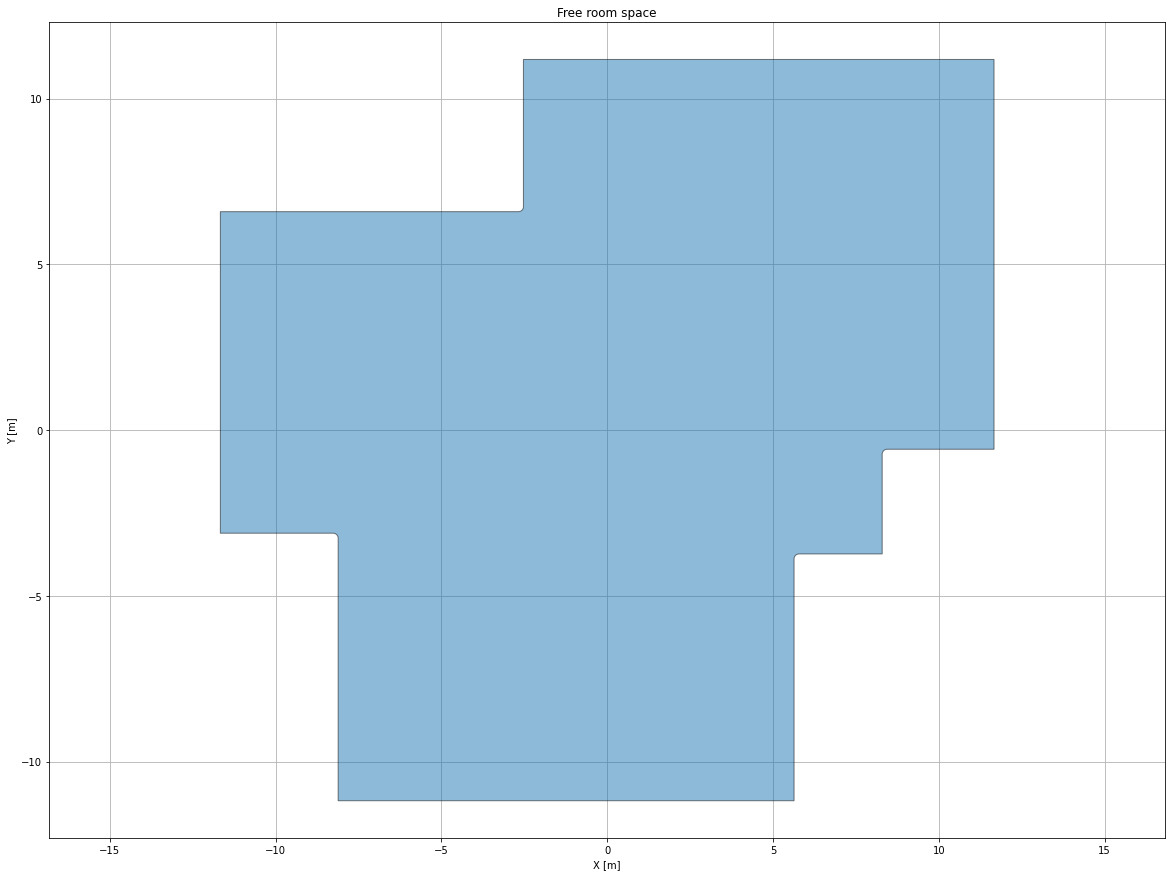

In [4]:
free_space_polygon = world_gen.world.get_free_space_polygon(
    ground_plane_models=[walls_model.name],
    ignore_models=['ground_plane'])

fig, ax = plot_shapely_geometry(free_space_polygon)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Free room space')
plt.show()

Add a workspace and a tangent constraint.

In [5]:
# Add constraint to place all object
# tangent to the ground
world_gen.add_constraint(
    name='tangent_to_ground_plane',
    type='tangent',
    frame='world',
    reference=dict(
        type='plane',
        args=dict(
            origin=[0, 0, 0],
            normal=[0, 0, 1]
        )
    )
)

world_gen.add_constraint(
    name='room_workspace',
    type='workspace',
    frame='world',
    geometry_type='polygon',
    polygon=free_space_polygon
)

print('List of constraints = ', world_gen.constraints.tags)

List of constraints =  ['tangent_to_ground_plane', 'room_workspace']


Add assets that will be dynamically generated when called by the random pose engine while populating the workspace.

In [6]:
# Add assets to the assets manager
world_gen.add_asset(
    tag='box',
    description=dict(
        type='box',
        args=dict(
            size="3 * __import__('pcg_gazebo').random.uniform(0.1, 1, 3)",
            name='cuboid',
            color='xkcd'
        )
    )
)

world_gen.add_asset(
    tag='cylinder',
    description=dict(
        type='cylinder',
        args=dict(
            radius="2 * __import__('pcg_gazebo').random.uniform(0.1, 1)",
            length="2 * __import__('pcg_gazebo').random.uniform(0.1, 1)",
            name='cylinder',
            color='xkcd'
        )
    )
)

world_gen.add_asset(
    tag='sphere',
    description=dict(
        type='sphere',
        args=dict(
            radius="2 * __import__('pcg_gazebo').random.uniform(0.1, 1)",
            name='sphere',
            color='xkcd'
        )
    )
)

True

## Setting maximum number of assets to add to world

In case the max. number of assets is set, the random pose engine will stop trying to place new assets to the world either when the maximum number of assets is reached or when there is no more collision-free room to add objects.

In [7]:
placement_policy = dict(
    models=['box', 'cylinder', 'sphere'],
    config=[
        dict(
            dofs=['x', 'y'],            
            tag='workspace',
            workspace='room_workspace'
        ),
        dict(
            dofs=['yaw'],            
            tag='uniform',                            
            min=-3.141592653589793,
            max=3.141592653589793               
        )
    ]
)

# Max. number of each asset as stopping criteria to the random pose engine
max_num=dict(
    box=4,
    cylinder=4,
    sphere=4)

world_gen.add_engine(
    tag='object_placement',
    engine_name='random_pose',
    models=['box', 'cylinder', 'sphere'],
    max_num=max_num,
    model_picker='random',
    no_collision=True,
    policies=[placement_policy],
    constraints=[
        dict(
            model='box',
            constraint='tangent_to_ground_plane'),
        dict(
            model='cylinder',
            constraint='tangent_to_ground_plane'),
        dict(
            model='sphere',
            constraint='tangent_to_ground_plane')
    ]
)

True

In [8]:
world_gen.run_engines(attach_models=True)

True

In [9]:
print('List of models ({}) = {}'.format(
    len(world_gen.world.models.keys()), world_gen.world.models.keys()))

List of models (14) = dict_keys(['walls', 'ground_plane', 'box', 'box_1', 'box_2', 'cylinder', 'sphere', 'cylinder_1', 'sphere_1', 'cylinder_2', 'box_3', 'cylinder_3', 'sphere_2', 'sphere_3'])


In [10]:
world_gen.world.create_scene().show()

## Setting maximum amount of assets and a minimum distance

In this use-case, the objects will be placed within the workspace only if the minimum distance to all other objects in the scene can also be respected.

In [11]:
reset_world()

In [12]:
MIN_DISTANCE = 1

world_gen.add_engine(
    tag='object_placement',
    engine_name='random_pose',
    models=['box', 'cylinder', 'sphere'],
    max_num=max_num,
    model_picker='random',
    no_collision=True,
    policies=[placement_policy],
    min_distance=MIN_DISTANCE,
    constraints=[
        dict(
            model='box',
            constraint='tangent_to_ground_plane'),
        dict(
            model='cylinder',
            constraint='tangent_to_ground_plane'),
        dict(
            model='sphere',
            constraint='tangent_to_ground_plane')
    ]
)

True

In [13]:
world_gen.run_engines(attach_models=True)

True

In [14]:
print('List of models ({}) = {}'.format(
    len(world_gen.world.models.keys()), world_gen.world.models.keys()))

List of models (14) = dict_keys(['walls', 'ground_plane', 'cylinder', 'sphere', 'cylinder_1', 'box', 'sphere_1', 'sphere_2', 'sphere_3', 'cylinder_2', 'cylinder_3', 'box_1', 'box_2', 'box_3'])


In [15]:
world_gen.world.create_scene().show()

## Setting no minimum amout of assets

In this case, the objects are placed until no free room is found within the workspace to place new objects.

In [16]:
reset_world()

In [17]:
world_gen.add_engine(
    tag='object_placement',
    engine_name='random_pose',
    models=['box', 'cylinder', 'sphere'],
    model_picker='random',
    no_collision=True,
    policies=[placement_policy],
    constraints=[
        dict(
            model='box',
            constraint='tangent_to_ground_plane'),
        dict(
            model='cylinder',
            constraint='tangent_to_ground_plane'),
        dict(
            model='sphere',
            constraint='tangent_to_ground_plane')
    ]
)

True

In [18]:
world_gen.run_engines(attach_models=True)

True

In [19]:
print('List of models ({}) = {}'.format(
    len(world_gen.world.models.keys()), world_gen.world.models.keys()))

List of models (71) = dict_keys(['walls', 'ground_plane', 'cylinder', 'sphere', 'sphere_1', 'sphere_2', 'sphere_3', 'cylinder_1', 'cylinder_2', 'box', 'box_1', 'box_2', 'box_3', 'box_4', 'sphere_4', 'cylinder_3', 'box_5', 'cylinder_4', 'cylinder_5', 'cylinder_6', 'sphere_5', 'cylinder_7', 'box_6', 'sphere_6', 'sphere_7', 'box_7', 'cylinder_8', 'sphere_8', 'sphere_9', 'cylinder_9', 'cylinder_10', 'sphere_10', 'cylinder_11', 'box_8', 'sphere_11', 'cylinder_12', 'cylinder_13', 'sphere_12', 'box_9', 'sphere_13', 'box_10', 'sphere_14', 'box_11', 'box_12', 'box_13', 'box_14', 'box_15', 'box_16', 'box_17', 'sphere_15', 'box_18', 'box_19', 'box_20', 'sphere_16', 'sphere_17', 'sphere_18', 'sphere_19', 'sphere_20', 'cylinder_14', 'box_21', 'box_22', 'cylinder_15', 'sphere_21', 'cylinder_16', 'cylinder_17', 'cylinder_18', 'sphere_22', 'cylinder_19', 'cylinder_20', 'sphere_23', 'sphere_24'])


In [20]:
world_gen.world.create_scene().show()

## Setting no minimum amount of objects but a minimum distance between objects

As in the example before, objects will be placed within the workspace until no free room in the workspace or no room where the minimum distance can be respected.

In [21]:
reset_world()

In [22]:
world_gen.add_engine(
    tag='object_placement',
    engine_name='random_pose',
    models=['box', 'cylinder', 'sphere'],
    model_picker='random',
    no_collision=True,
    min_distance=MIN_DISTANCE,
    policies=[placement_policy],
    constraints=[
        dict(
            model='box',
            constraint='tangent_to_ground_plane'),
        dict(
            model='cylinder',
            constraint='tangent_to_ground_plane'),
        dict(
            model='sphere',
            constraint='tangent_to_ground_plane')
    ]
)

True

In [23]:
world_gen.run_engines(attach_models=True)

True

In [24]:
print('List of models ({}) = {}'.format(
    len(world_gen.world.models.keys()), world_gen.world.models.keys()))

List of models (21) = dict_keys(['walls', 'ground_plane', 'box', 'cylinder', 'sphere', 'box_1', 'cylinder_1', 'cylinder_2', 'box_2', 'cylinder_3', 'sphere_1', 'box_3', 'cylinder_4', 'cylinder_5', 'cylinder_6', 'box_4', 'sphere_2', 'sphere_3', 'cylinder_7', 'cylinder_8', 'cylinder_9'])


In [25]:
world_gen.world.create_scene().show()